In [44]:
"""Setup and preproccessing"""
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error

torch.manual_seed(11)
ticker = 'AAPL'
start_date = '2022-07-01'
end_date = '2025-10-31'

data = yf.download(ticker, start=start_date, end=end_date)
df = pd.DataFrame(data['Close'])

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

#convert into column matrix
data_tensor = torch.FloatTensor(df_scaled).view(-1)

[*********************100%%**********************]  1 of 1 completed


In [45]:
"""Setting up data to input into LSTM model. Sequencing for the LSTM to extract patterns."""
def create_sequences(data, seq_length):
    """Pattern extraction over seq_length for a given dataset."""
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = torch.tensor(data[i:i+seq_length], dtype=torch.float32) 
        target = torch.tensor(data[i+seq_length:i+seq_length+1], dtype=torch.float32) #single value for the sequence to learn direction towards
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.stack(targets).view(-1)

sequence_length = 10
train_size = int(len(df_scaled) * 0.80) 
train_data= df_scaled[0:train_size]
test_data = df_scaled[train_size:len(df_scaled)]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [46]:
"""Model and parameter setup"""
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=35, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [47]:
epochs = 75

for epoch in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        labels = labels.view_as(y_pred)

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

#train
model.eval()
train_predictions = []
for seq in X_train: 
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        train_predictions.append(model(seq).item())

#unseen prediction
test_predictions = []
for seq in X_test: #still using input from real information
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq).item())

train_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

Train RMSE: 4.66
Test RMSE: 4.03


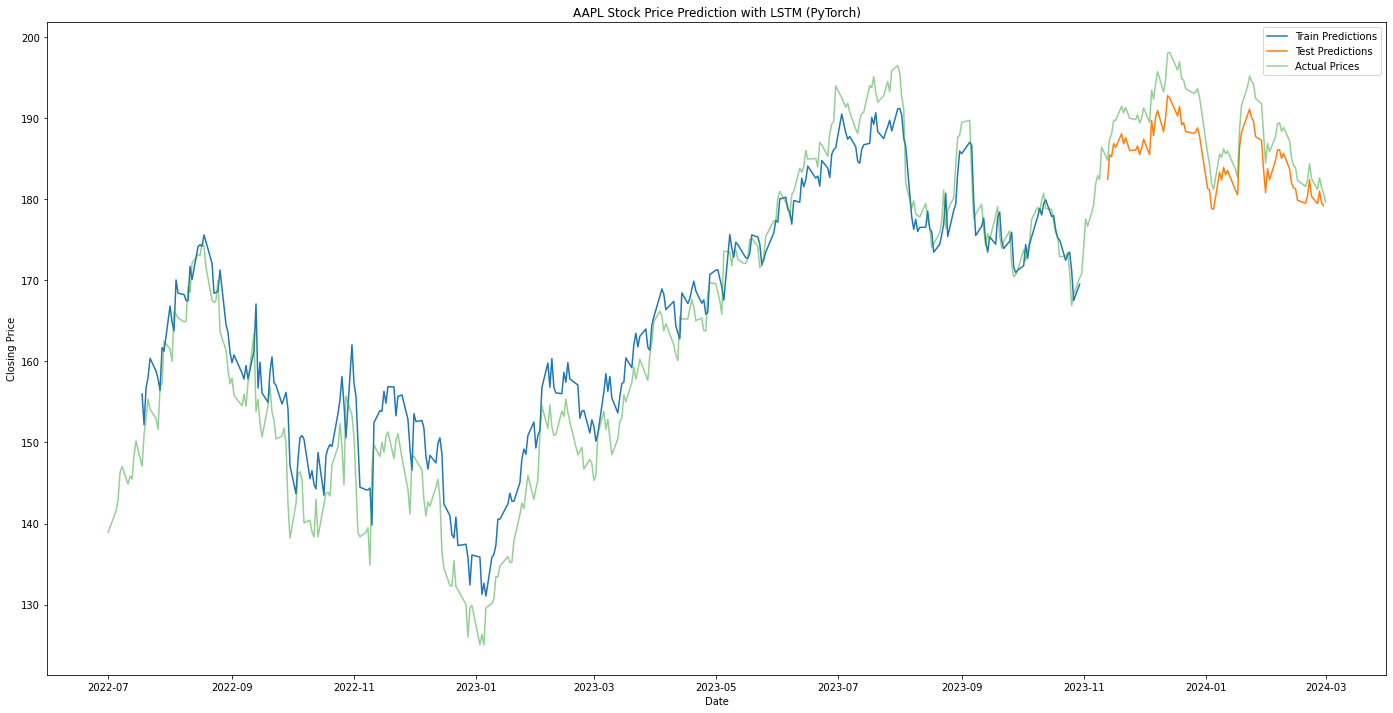

In [48]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predictions))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
plt.figure(figsize=(24, 12))
plt.plot(df.index[sequence_length:sequence_length + len(train_predictions)], train_predictions, label='Train Predictions')

test_index = df.index[sequence_length + len(train_predictions) + sequence_length - 1:]
plt.plot(test_index[:len(test_predictions)], test_predictions, label='Test Predictions')

plt.plot(df.index, df['Close'], label='Actual Prices', alpha=0.5)

plt.title(f'{ticker} Stock Price Prediction with LSTM (PyTorch)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



[[177.8925821 ]
 [176.36058271]]
Future RMSE: 10.65


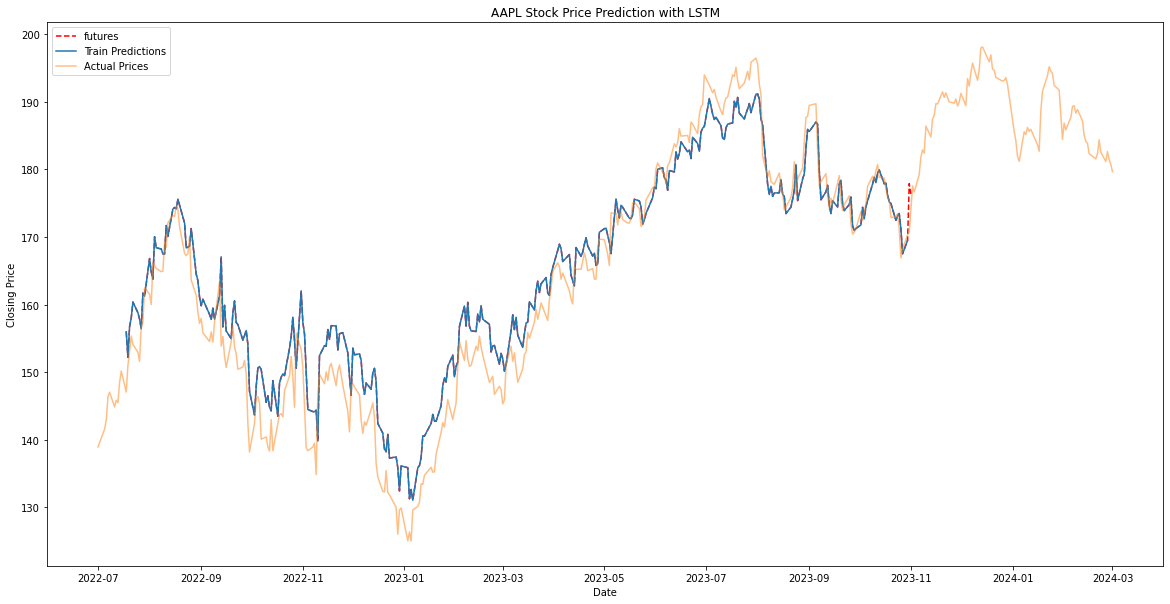

In [49]:
def predict_future(model, initial_sequence, num_steps):
    future_predictions = []

    with torch.no_grad():
        current_sequence = initial_sequence
        for _ in range(num_steps):
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            next_pred = model(current_sequence)
            future_predictions.append(next_pred.item())
            current_sequence = torch.cat((current_sequence[1:], next_pred.view(1, 1)), dim=0) #concantenate

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions


initial_sequence = torch.FloatTensor(test_data[-sequence_length:])

num_future_steps = 2 #in terms of sequence

future_predictions = predict_future(model, initial_sequence, num_future_steps)
print(future_predictions)


all_predictions = np.concatenate([train_predictions, future_predictions])
future_actuals = y_test_inv[:len(future_predictions)]
future_rmse = np.sqrt(mean_squared_error(future_predictions, future_actuals))

print(f"Future RMSE: {future_rmse:.2f}")


plt.figure(figsize=(20, 10))
plt.plot(df.index[sequence_length:sequence_length + len(all_predictions)], all_predictions, label='futures', linestyle='dashed', color='red')
plt.plot(df.index[sequence_length:sequence_length + len(train_predictions)], train_predictions, label='Train Predictions')
plt.plot(df.index, df['Close'], label='Actual Prices', alpha=0.5)

plt.title(f'{ticker} Stock Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

